# Grating Coupler: Bayesian Optimization for Initial Design

> With our simulation setup in place, we now turn to optimization. Our goal is to find a set of grating parameters that maximizes the coupling efficiency. Since each simulation is computationally expensive, we will use Bayesian optimization. This technique is ideal for optimizing "black-box" functions that are costly to evaluate.

## Why Bayesian Optimization?

Exhaustive searches would require thousands of simulations. Bayesian optimization instead builds a probabilistic surrogate of the objective, balancing exploration of uncertain regions with exploitation of promising designs to converge in far fewer solver calls. It intelligently explores the parameter space to find the optimal design with a minimal number of simulations. Bayesian optimization works best when the design space has only a handful of effective degrees of freedom; beyond roughly five independent variables the surrogate becomes harder to learn, so we reserve higher-dimensional searches for gradient-based methods discussed later in the series.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
from bayes_opt import BayesianOptimization
from setup import (
    center_wavelength,
    get_mode_monitor_power,
    make_simulation,
    max_gap_si,
    max_gap_sin,
    max_width_si,
    max_width_sin,
    min_gap_si,
    min_gap_sin,
    min_width_si,
    min_width_sin,
    num_elements,
)
from setup import (
    first_gap_si as default_first_gap_si,
)
from tidy3d import web

## The Evaluation Function

The optimizer queries this function with a candidate set of grating parameters. We construct the simulation, run it in the cloud, and return the coupling efficiency from the mode monitor.

In [2]:
def evaluate(
    width_si: float,
    gap_si: float,
    width_sin: float,
    gap_sin: float,
    first_gap_si: float,
) -> float:
    """Return the coupling efficiency for a uniform grating parameterized array."""
    widths_si = np.full(num_elements, width_si)
    gaps_si = np.full(num_elements, gap_si)
    widths_sin = np.full(num_elements, width_sin)
    gaps_sin = np.full(num_elements, gap_sin)

    sim = make_simulation(
        widths_si,
        gaps_si,
        widths_sin,
        gaps_sin,
        first_gap_si=first_gap_si,
    )
    sim_data = web.run(sim, task_name="gc_bopt_eval", verbose=False)

    power_da = get_mode_monitor_power(sim_data)
    target_power = power_da.sel(f=td.C_0 / center_wavelength, method="nearest").item()

    return target_power

## Setting Up the Bayesian Optimizer

We configure the optimizer with sensible defaults and practical bounds:
- `parameter_bounds` (the `pbounds` argument) defines the design window we explore.
- `init_points` sets how many random samples to collect before modeling.
- `n_iter` controls the number of guided optimization iterations.

## Framing the Problem: A 5-Parameter Global Search

Rather than tune every tooth individually (30 variables per layer), we search a five-dimensional space of uniform widths, gaps, and inter-layer offset. This captures the dominant physics, keeps simulations fast, and yields a design that later gradient-based passes can refine.

In [3]:
seed = 12345

init_points = 15
n_iter = 60

parameter_bounds = {
    "width_si": (min_width_si, max_width_si),
    "gap_si": (min_gap_si, max_gap_si),
    "width_sin": (min_width_sin, max_width_sin),
    "gap_sin": (min_gap_sin, max_gap_sin),
    "first_gap_si": (
        default_first_gap_si - 0.2,
        default_first_gap_si + 0.2,
    ),
}

default_design = {
    "width_si": 0.45,
    "gap_si": 0.55,
    "width_sin": 0.35,
    "gap_sin": 0.65,
    "first_gap_si": default_first_gap_si,
}

In [4]:
optimizer = BayesianOptimization(
    f=evaluate,
    pbounds=parameter_bounds,
    random_state=seed,
    verbose=2,
)

optimizer.probe(params=default_design, lazy=True)

## Running the Optimization

Calling `optimizer.maximize(...)` alternates between exploration and exploitation to efficiently discover improved grating designs.

In [5]:
optimizer.maximize(init_points=init_points, n_iter=n_iter)

|   iter    |  target   | first_... |  gap_si   |  gap_sin  | width_si  | width_sin |
-------------------------------------------------------------------------------------
| 1         | 0.007373  | -0.7      | 0.55      | 0.65      | 0.45      | 0.35      |
| 2         | 0.001166  | -0.5282   | 0.4531    | 0.4287    | 0.2841    | 0.6542    |
| 3         | 0.002181  | -0.6618   | 0.9716    | 0.7572    | 0.774     | 0.7229    |
| 4         | 0.04058   | -0.6009   | 0.969     | 0.3059    | 0.1958    | 0.439     |
| 5         | 0.0007281 | -0.6374   | 0.8479    | 0.9105    | 0.9682    | 0.7789    |
| 6         | 0.181     | -0.643    | 0.774     | 0.6273    | 0.393     | 0.5517    |
| 7         | 0.00206   | -0.6081   | 0.9952    | 0.7738    | 0.8117    | 0.3367    |
| 8         | 0.0008147 | -0.8893   | 0.8403    | 0.9326    | 0.1222    | 0.5934    |
| 9         | 0.01132   | -0.6895   | 0.6771    | 0.3364    | 0.9056    | 0.7826    |
| 10        | 0.009404  | -0.5727   | 0.6002    | 0.86

## Analyzing the Results

We extract the optimizer history, track the best observed loss, and visualize how the search converges toward high-efficiency gratings.

In [6]:
best = optimizer.max

results = optimizer.res
iterations = np.arange(1, len(results) + 1)
targets = np.asarray([res["target"] for res in results], dtype=float)
targets = np.maximum(targets, 1e-12)
coupling_loss_db = -10 * np.log10(targets)
best_loss = np.minimum.accumulate(coupling_loss_db)

best_loss_db = -10 * np.log10(max(best["target"], 1e-12))

print("Optimization complete.")
print(f"Best parameters: {best['params']}")
print(f"Best objective (power): {best['target']}")
print(f"Best objective (dB): {best_loss_db:.2f}")

Optimization complete.
Best parameters: {'first_gap_si': np.float64(-0.6933388041768698), 'gap_si': np.float64(0.7992416233438039), 'gap_sin': np.float64(0.5135103145142313), 'width_si': np.float64(0.3983180007432449), 'width_sin': np.float64(0.5781958117277934)}
Best objective (power): 0.3425821844561507
Best objective (dB): 4.65


## Interpreting the Optimization Progress

The scatter points show every simulation the optimizer evaluated, while the red curve tracks the best coupling loss found so far. Early iterations explore widely; later ones cluster near promising regions as the surrogate model focuses on exploitation.

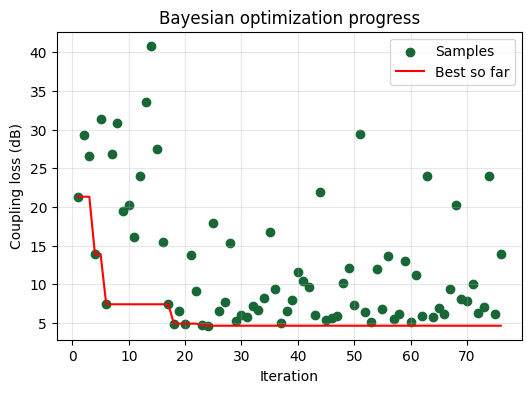

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(iterations, coupling_loss_db, label="Samples")
ax.plot(iterations, best_loss, color="red", label="Best so far")
ax.set_xlabel("Iteration")
ax.set_ylabel("Coupling loss (dB)")
ax.set_title("Bayesian optimization progress")
ax.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Visualizing the Optimized Design

We reconstruct the best-performing structure, inspect its geometry, and analyze the spectral response to confirm the optimizer's progress.

In [8]:
best_params = {name: float(value) for name, value in best["params"].items()}
best_widths_si = np.full(num_elements, best_params["width_si"])
best_gaps_si = np.full(num_elements, best_params["gap_si"])
best_widths_sin = np.full(num_elements, best_params["width_sin"])
best_gaps_sin = np.full(num_elements, best_params["gap_sin"])
best_first_gap_si = best_params["first_gap_si"]

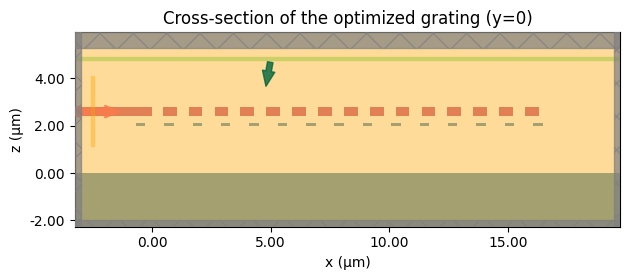

In [9]:
best_sim = make_simulation(
    best_widths_si,
    best_gaps_si,
    best_widths_sin,
    best_gaps_sin,
    first_gap_si=best_first_gap_si,
    include_field_monitor=True,
)
ax = best_sim.plot(y=0)
ax.set_title("Cross-section of the optimized grating (y=0)")
plt.show()

In [10]:
best_data = web.run(best_sim, task_name="gc_bopt_final", verbose=False)

In [11]:
power_da = get_mode_monitor_power(best_data)
freqs = power_da.coords["f"].values
wavelengths = td.C_0 / freqs
power = np.squeeze(power_da.data)
power_db = 10 * np.log10(power)

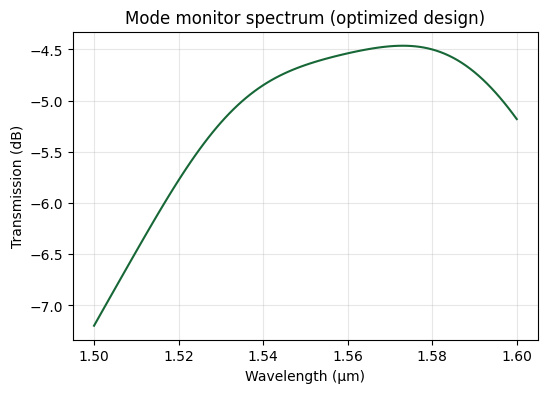

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(wavelengths, power_db)
ax.set_xlabel("Wavelength (µm)")
ax.set_ylabel("Transmission (dB)")
ax.set_title("Mode monitor spectrum (optimized design)")
ax.grid(True, alpha=0.3)
plt.show()

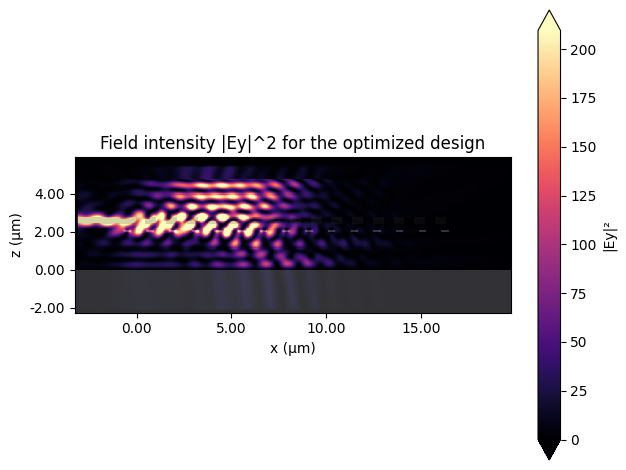

In [13]:
ax = best_data.plot_field("field_monitor", "Ey", "abs^2")
ax.set_title("Field intensity |Ey|^2 for the optimized design")
plt.show()

The optimized geometry increases overlap between the free-space beam and the guided mode, yielding a stronger steady-state field inside the silicon nitride layer. In the next notebook we leverage this design as the starting point for gradient-based refinement.

## Exporting the Best Design

We serialize the best uniform grating parameters so the adjoint notebook can continue from this design without rerunning the Bayesian search.

In [14]:
import json
from pathlib import Path

export_path = Path("./results/gc_bayes_opt_best.json")
export_path.parent.mkdir(parents=True, exist_ok=True)

export_payload = {
    "width_si": best_params["width_si"],
    "gap_si": best_params["gap_si"],
    "width_sin": best_params["width_sin"],
    "gap_sin": best_params["gap_sin"],
    "first_gap_si": best_params["first_gap_si"],
    "target_power": float(best["target"]),
    "coupling_loss_db": float(best_loss_db),
}

with export_path.open("w", encoding="utf-8") as f:
    json.dump(export_payload, f, indent=2)

print(f"Saved best design to {export_path.resolve()}")

Saved best design to /home/yannick/flexcompute/worktrees/seminar_notebooks/docs/notebooks/2025-10-09-invdes-seminar/results/gc_bayes_opt_best.json
